In [1]:
import os
import pandas as pd
import sklearn.metrics
import numpy as np
import plotnine as p9
import optuna
import scipy.stats as stats 
import itertools
import warnings
warnings.filterwarnings('ignore')

/opt/homebrew/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
TRIALS = 250
TOP_N = 1

In [3]:
def load_performance_metrics(dataset, gnn, llm, method, aggregation, display_information = False):
  
  study_name = f'{dataset}-{gnn}-{llm.replace("/", "-")}-{method}-{aggregation}'
  storage = f'sqlite:///../../pipelines/optuna_studies/{study_name}.db'
  study = optuna.load_study(study_name = study_name, storage = storage)
  
  study_df = study.trials_dataframe()

  study_df = study_df[study_df['value'] >= 0.0].sort_values(by = 'number', ascending = True)
  columns = ['number', 'value'] + [x for x in study_df.columns if x.startswith('params_')] + [x for x in study_df.columns if x.startswith('user_attrs_')]

  top_trials = study_df[columns].head(TRIALS).sort_values(by = ['value', 'user_attrs_validation_loss', 'user_attrs_training_loss'], ascending = [False, True, True]).head(TOP_N)
  
  performance = list()
  #for trial in [x for x in os.listdir(f'../../outputs/{dataset}-{gnn}-{llm}/{method}/{aggregation}') if os.path.isdir(f'../../outputs/{dataset}-{gnn}-{llm}/{method}/{aggregation}/{x}')]:
  for _, row in top_trials.iterrows():
    
    if display_information:
      print(row)
    trial = row['number']

    for random_state in [x for x in os.listdir(f'../../outputs/{dataset}-{gnn}-{llm}/{method}/{aggregation}/{trial}') if os.path.isdir(f'../../outputs/{dataset}-{gnn}-{llm}/{method}/{aggregation}/{trial}/{x}')]:
      df = pd.read_csv(f'../../outputs/{dataset}-{gnn}-{llm}/{method}/{aggregation}/{trial}/{random_state}/predictions.csv')
      for split in ['validation', 'test']:
        df_split = df[df['split'] == split]
        accuracy = sklearn.metrics.accuracy_score(df_split['real'], df_split['prediction'])
        f1_score = sklearn.metrics.f1_score(df_split['real'], df_split['prediction'], average = 'macro')
        precision = sklearn.metrics.precision_score(df_split['real'], df_split['prediction'], average = 'macro')
        recall = sklearn.metrics.recall_score(df_split['real'], df_split['prediction'], average = 'macro')
        performance.append((trial, random_state, split, accuracy, f1_score, precision, recall))
  return pd.DataFrame(performance, columns = ['trial', 'random_state', 'split', 'accuracy', 'f1_score', 'precision', 'recall'])

In [4]:
def remove_trials_with_exceptions(df):
  return df.groupby(['trial']).filter(lambda x : len(x) >= 10 * 2).reset_index(drop = True)

In [5]:
def get_best_results(dataset, gnn, llm, method, aggregation, target_metric):
  df = load_performance_metrics(dataset = dataset, gnn = gnn, llm = llm, method = method, aggregation = aggregation, display_information = True)
  df = remove_trials_with_exceptions(df)
  df_aggregated = df.groupby(['trial', 'split']).agg({
    'accuracy' : ['mean', 'std'],
    'f1_score' : ['mean', 'std'],
    'precision' : ['mean', 'std'],
    'recall' : ['mean', 'std'],
  }).reset_index()
  df_aggregated.columns = df_aggregated.columns.map('_'.join).str.strip('_')
  
  best_trial_number = df_aggregated.sort_values(by = ['split', f'{target_metric}_mean', f'{target_metric}_std'], ascending = [True, False, True]).reset_index(drop = True).iloc[0]['trial']

  best_trial = df_aggregated[df_aggregated['trial'] == best_trial_number]

  print(best_trial_number)
  print('-' * 10, 'Validation', '-' * 10)

  print(
    'Accuracy:',
    '{:.2f}'.format(np.round(best_trial[best_trial['split'] == 'validation']['accuracy_mean'].values[0] * 100, decimals = 2)),
    '±',
    '{:.2f}'.format(np.round(best_trial[best_trial['split'] == 'validation']['accuracy_std'].values[0] * 100, decimals = 2))
  )
  print(
    'F1-score:',
    '{:.2f}'.format(np.round(best_trial[best_trial['split'] == 'validation']['f1_score_mean'].values[0] * 100, decimals = 2)),
    '±',
    '{:.2f}'.format(np.round(best_trial[best_trial['split'] == 'validation']['f1_score_std'].values[0] * 100, decimals = 2))
  )
  print(
    'Precision:',
    '{:.2f}'.format(np.round(best_trial[best_trial['split'] == 'validation']['precision_mean'].values[0] * 100, decimals = 2)),
    '±',
    '{:.2f}'.format(np.round(best_trial[best_trial['split'] == 'validation']['precision_std'].values[0] * 100, decimals = 2))
  )
  print(
    'Recall:',
    '{:.2f}'.format(np.round(best_trial[best_trial['split'] == 'validation']['recall_mean'].values[0] * 100, decimals = 2)),
    '±',
    '{:.2f}'.format(np.round(best_trial[best_trial['split'] == 'validation']['recall_std'].values[0] * 100, decimals = 2))
  )

  print('-' * 10, 'Test', '-' * 10)

  print(
    'Accuracy:',
    '{:.2f}'.format(np.round(best_trial[best_trial['split'] == 'test']['accuracy_mean'].values[0] * 100, decimals = 2)),
    '±', 
    '{:.2f}'.format(np.round(best_trial[best_trial['split'] == 'test']['accuracy_std'].values[0] * 100, decimals = 2))
  )
  print(
    'F1-score:',
    '{:.2f}'.format(np.round(best_trial[best_trial['split'] == 'test']['f1_score_mean'].values[0] * 100, decimals = 2)),
    '±',
    '{:.2f}'.format(np.round(best_trial[best_trial['split'] == 'test']['f1_score_std'].values[0] * 100, decimals = 2))
  )
  print(
    'Precision:',
    '{:.2f}'.format(np.round(best_trial[best_trial['split'] == 'test']['precision_mean'].values[0] * 100, decimals = 2)),
    '±',
    '{:.2f}'.format(np.round(best_trial[best_trial['split'] == 'test']['precision_std'].values[0] * 100, decimals = 2))
  )
  print(
    'Recall:',
    '{:.2f}'.format(np.round(best_trial[best_trial['split'] == 'test']['recall_mean'].values[0] * 100, decimals = 2)),
    '±',
    '{:.2f}'.format(np.round(best_trial[best_trial['split'] == 'test']['recall_std'].values[0] * 100, decimals = 2))
  )


# RQ 1

---------

## SST-2

In [6]:
get_best_results(dataset = 'SST-2', gnn = 'GAT', llm = 'google-bert-bert-base-uncased', method = 'Grouped', aggregation = 'No_Aggregation', target_metric = 'accuracy')

number                                     203
value                                 0.911697
params_attention_heads                       9
params_attention_pooling_operation        mean
params_balanced_loss                     False
params_batch_size                           46
params_beta_0                         0.854046
params_beta_1                         0.997201
params_dropout_rate                   0.575221
params_early_stopping_patience              25
params_embedding_pooling_operation         max
params_epochs                               98
params_epsilon                        0.000002
params_global_pooling                     mean
params_hidden_dimension                     68
params_learning_rate                  0.000866
params_number_of_hidden_layers               0
params_plateau_divider                       2
params_plateau_patience                     20
params_threshold                      0.663378
params_weight_decay                   0.000019
user_attrs_ep

In [7]:
get_best_results(dataset = 'SST-2', gnn = 'GAT', llm = 'google-bert-bert-base-uncased', method = 'Surrogate', aggregation = 'No_Aggregation', target_metric = 'accuracy')

number                                     190
value                                 0.909404
params_attention_heads                      14
params_attention_pooling_operation        mean
params_balanced_loss                     False
params_batch_size                           40
params_beta_0                         0.880708
params_beta_1                         0.985934
params_dropout_rate                   0.300565
params_early_stopping_patience              24
params_embedding_pooling_operation        mean
params_epochs                               68
params_epsilon                        0.000001
params_global_pooling                     mean
params_hidden_dimension                    225
params_learning_rate                  0.000452
params_number_of_hidden_layers               1
params_plateau_divider                      10
params_plateau_patience                     23
params_threshold                      0.597401
params_weight_decay                   0.000001
user_attrs_ep

In [6]:
get_best_results(dataset = 'SST-2', gnn = 'GATv2', llm = 'google-bert-bert-base-uncased', method = 'Grouped', aggregation = 'No_Aggregation', target_metric = 'accuracy')

number                                     221
value                                  0.91055
params_attention_heads                       7
params_attention_pooling_operation         min
params_balanced_loss                      True
params_batch_size                           67
params_beta_0                         0.836906
params_beta_1                         0.988719
params_dropout_rate                   0.469089
params_early_stopping_patience              23
params_embedding_pooling_operation         max
params_epochs                               69
params_epsilon                             0.0
params_global_pooling                      max
params_hidden_dimension                    238
params_learning_rate                  0.000592
params_number_of_hidden_layers               2
params_plateau_divider                       6
params_plateau_patience                     19
params_threshold                      0.574329
params_weight_decay                   0.000125
user_attrs_ep

In [7]:
get_best_results(dataset = 'SST-2', gnn = 'GATv2', llm = 'google-bert-bert-base-uncased', method = 'Surrogate', aggregation = 'No_Aggregation', target_metric = 'accuracy')

number                                     255
value                                 0.912844
params_attention_heads                      16
params_attention_pooling_operation         max
params_balanced_loss                      True
params_batch_size                           77
params_beta_0                         0.834165
params_beta_1                         0.981367
params_dropout_rate                   0.454022
params_early_stopping_patience              15
params_embedding_pooling_operation         max
params_epochs                              197
params_epsilon                        0.000002
params_global_pooling                     mean
params_hidden_dimension                    196
params_learning_rate                  0.001156
params_number_of_hidden_layers               3
params_plateau_divider                       5
params_plateau_patience                     11
params_threshold                       0.48984
params_weight_decay                   0.000007
user_attrs_ep

---------

## R8

In [10]:
get_best_results(dataset = 'R8', gnn = 'GAT', llm = 'google-bert-bert-base-uncased', method = 'Grouped', aggregation = 'No_Aggregation', target_metric = 'f1_score')

number                                     238
value                                 0.962839
params_attention_heads                      13
params_attention_pooling_operation        mean
params_balanced_loss                     False
params_batch_size                           91
params_beta_0                         0.845257
params_beta_1                          0.99069
params_dropout_rate                   0.593587
params_early_stopping_patience              24
params_embedding_pooling_operation         max
params_epochs                               53
params_epsilon                        0.000002
params_global_pooling                      max
params_hidden_dimension                     89
params_learning_rate                  0.000225
params_left_stride                           0
params_number_of_hidden_layers               3
params_plateau_divider                       8
params_plateau_patience                     12
params_right_stride                         32
params_thresh

In [11]:
get_best_results(dataset = 'R8', gnn = 'GAT', llm = 'google-bert-bert-base-uncased', method = 'Surrogate', aggregation = 'No_Aggregation', target_metric = 'f1_score')

number                                     267
value                                  0.95534
params_attention_heads                       4
params_attention_pooling_operation         min
params_balanced_loss                     False
params_batch_size                          184
params_beta_0                         0.896211
params_beta_1                         0.981795
params_dropout_rate                   0.526503
params_early_stopping_patience              16
params_embedding_pooling_operation        mean
params_epochs                               76
params_epsilon                             0.0
params_global_pooling                      max
params_hidden_dimension                     95
params_learning_rate                   0.00134
params_left_stride                          32
params_number_of_hidden_layers               0
params_plateau_divider                       7
params_plateau_patience                     22
params_right_stride                         32
params_thresh

In [8]:
get_best_results(dataset = 'R8', gnn = 'GATv2', llm = 'google-bert-bert-base-uncased', method = 'Grouped', aggregation = 'No_Aggregation', target_metric = 'f1_score')

number                                     220
value                                 0.966294
params_attention_heads                       6
params_attention_pooling_operation        mean
params_balanced_loss                     False
params_batch_size                           92
params_beta_0                         0.895508
params_beta_1                         0.987714
params_dropout_rate                   0.552551
params_early_stopping_patience              20
params_embedding_pooling_operation         min
params_epochs                               64
params_epsilon                             0.0
params_global_pooling                      max
params_hidden_dimension                    125
params_learning_rate                  0.000316
params_left_stride                          32
params_number_of_hidden_layers               2
params_plateau_divider                       9
params_plateau_patience                     23
params_right_stride                        128
params_thresh

In [9]:
get_best_results(dataset = 'R8', gnn = 'GATv2', llm = 'google-bert-bert-base-uncased', method = 'Surrogate', aggregation = 'No_Aggregation', target_metric = 'f1_score')

number                                     215
value                                 0.957508
params_attention_heads                       8
params_attention_pooling_operation         max
params_balanced_loss                     False
params_batch_size                          110
params_beta_0                         0.816872
params_beta_1                         0.996901
params_dropout_rate                   0.348761
params_early_stopping_patience              20
params_embedding_pooling_operation         max
params_epochs                               72
params_epsilon                        0.000002
params_global_pooling                      max
params_hidden_dimension                     37
params_learning_rate                  0.000097
params_left_stride                          32
params_number_of_hidden_layers               2
params_plateau_divider                       2
params_plateau_patience                     23
params_right_stride                          0
params_thresh

## Ohsumed

In [14]:
get_best_results(dataset = 'Ohsumed', gnn = 'GAT', llm = 'google-bert-bert-base-uncased', method = 'Grouped', aggregation = 'No_Aggregation', target_metric = 'f1_score')

number                                     168
value                                 0.658663
params_attention_heads                      15
params_attention_pooling_operation        mean
params_balanced_loss                     False
params_batch_size                           98
params_beta_0                         0.875638
params_beta_1                         0.988902
params_dropout_rate                   0.318724
params_early_stopping_patience              22
params_embedding_pooling_operation        mean
params_epochs                              126
params_epsilon                             0.0
params_global_pooling                      max
params_hidden_dimension                    105
params_learning_rate                  0.000326
params_left_stride                           0
params_number_of_hidden_layers               2
params_plateau_divider                       2
params_plateau_patience                     21
params_right_stride                          0
params_thresh

In [15]:
get_best_results(dataset = 'Ohsumed', gnn = 'GAT', llm = 'google-bert-bert-base-uncased', method = 'Surrogate', aggregation = 'No_Aggregation', target_metric = 'f1_score')

number                                     193
value                                 0.625517
params_attention_heads                      12
params_attention_pooling_operation         min
params_balanced_loss                     False
params_batch_size                           60
params_beta_0                         0.873007
params_beta_1                         0.989199
params_dropout_rate                   0.342091
params_early_stopping_patience              20
params_embedding_pooling_operation        mean
params_epochs                               56
params_epsilon                        0.000019
params_global_pooling                     mean
params_hidden_dimension                    244
params_learning_rate                  0.001286
params_left_stride                         128
params_number_of_hidden_layers               1
params_plateau_divider                       8
params_plateau_patience                     12
params_right_stride                         64
params_thresh

In [10]:
get_best_results(dataset = 'Ohsumed', gnn = 'GATv2', llm = 'google-bert-bert-base-uncased', method = 'Grouped', aggregation = 'No_Aggregation', target_metric = 'f1_score')

number                                     291
value                                 0.657566
params_attention_heads                      14
params_attention_pooling_operation         max
params_balanced_loss                     False
params_batch_size                           40
params_beta_0                         0.821612
params_beta_1                         0.985736
params_dropout_rate                   0.397687
params_early_stopping_patience              18
params_embedding_pooling_operation        mean
params_epochs                              171
params_epsilon                        0.000007
params_global_pooling                      max
params_hidden_dimension                    241
params_learning_rate                  0.000142
params_left_stride                           0
params_number_of_hidden_layers               2
params_plateau_divider                       9
params_plateau_patience                     10
params_right_stride                         64
params_thresh

In [11]:
get_best_results(dataset = 'Ohsumed', gnn = 'GATv2', llm = 'google-bert-bert-base-uncased', method = 'Surrogate', aggregation = 'No_Aggregation', target_metric = 'f1_score')

number                                     417
value                                 0.655114
params_attention_heads                       9
params_attention_pooling_operation         max
params_balanced_loss                     False
params_batch_size                           36
params_beta_0                         0.815749
params_beta_1                         0.981366
params_dropout_rate                    0.35046
params_early_stopping_patience              16
params_embedding_pooling_operation         min
params_epochs                               59
params_epsilon                         0.00008
params_global_pooling                      max
params_hidden_dimension                    105
params_learning_rate                  0.000311
params_left_stride                         256
params_number_of_hidden_layers               2
params_plateau_divider                      10
params_plateau_patience                     12
params_right_stride                         64
params_thresh

## IMDb Top 1k

In [6]:
get_best_results(dataset = 'IMDb-top_1000', gnn = 'GAT', llm = 'google-bert-bert-base-uncased', method = 'Grouped', aggregation = 'No_Aggregation', target_metric = 'accuracy')

number                                     245
value                                 0.927273
params_attention_heads                       5
params_attention_pooling_operation         min
params_balanced_loss                      True
params_batch_size                           31
params_beta_0                         0.859616
params_beta_1                         0.991756
params_dropout_rate                   0.515756
params_early_stopping_patience              21
params_embedding_pooling_operation        mean
params_epochs                               62
params_epsilon                        0.000001
params_global_pooling                     mean
params_hidden_dimension                    204
params_learning_rate                  0.000387
params_left_stride                          64
params_number_of_hidden_layers               0
params_plateau_divider                       9
params_plateau_patience                     22
params_right_stride                        128
params_thresh

In [7]:
get_best_results(dataset = 'IMDb-top_1000', gnn = 'GAT', llm = 'google-bert-bert-base-uncased', method = 'Surrogate', aggregation = 'No_Aggregation', target_metric = 'accuracy')

number                                     175
value                                 0.933333
params_attention_heads                       5
params_attention_pooling_operation        mean
params_balanced_loss                     False
params_batch_size                           63
params_beta_0                         0.810369
params_beta_1                         0.997473
params_dropout_rate                   0.505874
params_early_stopping_patience              22
params_embedding_pooling_operation         max
params_epochs                              189
params_epsilon                             0.0
params_global_pooling                     mean
params_hidden_dimension                    105
params_learning_rate                  0.000713
params_left_stride                           0
params_number_of_hidden_layers               4
params_plateau_divider                       7
params_plateau_patience                     16
params_right_stride                         64
params_thresh

In [12]:
get_best_results(dataset = 'IMDb-top_1000', gnn = 'GATv2', llm = 'google-bert-bert-base-uncased', method = 'Grouped', aggregation = 'No_Aggregation', target_metric = 'accuracy')

number                                     234
value                                 0.933333
params_attention_heads                      12
params_attention_pooling_operation         min
params_balanced_loss                     False
params_batch_size                           43
params_beta_0                         0.880051
params_beta_1                         0.993488
params_dropout_rate                   0.415888
params_early_stopping_patience              25
params_embedding_pooling_operation         min
params_epochs                              130
params_epsilon                        0.000066
params_global_pooling                     mean
params_hidden_dimension                     91
params_learning_rate                  0.001038
params_left_stride                         128
params_number_of_hidden_layers               2
params_plateau_divider                       7
params_plateau_patience                     11
params_right_stride                         64
params_thresh

In [13]:
get_best_results(dataset = 'IMDb-top_1000', gnn = 'GATv2', llm = 'google-bert-bert-base-uncased', method = 'Surrogate', aggregation = 'No_Aggregation', target_metric = 'accuracy')

number                                     250
value                                 0.933333
params_attention_heads                       5
params_attention_pooling_operation        mean
params_balanced_loss                     False
params_batch_size                           26
params_beta_0                         0.822301
params_beta_1                         0.997692
params_dropout_rate                   0.577056
params_early_stopping_patience              23
params_embedding_pooling_operation         min
params_epochs                              136
params_epsilon                        0.000003
params_global_pooling                     mean
params_hidden_dimension                     63
params_learning_rate                  0.000728
params_left_stride                         128
params_number_of_hidden_layers               4
params_plateau_divider                       7
params_plateau_patience                     17
params_right_stride                        256
params_thresh

## Visual analysis

In [14]:
def get_best_results_for_plot(datasets, gnns, llm, methods, aggregation, target_metrics):
  results = list()
  for dataset, target_metric in zip(datasets, target_metrics):
    for gnn in gnns:
      for method in methods:
        df = load_performance_metrics(dataset = dataset, gnn = gnn, llm = llm, method = method, aggregation = aggregation)
        df = remove_trials_with_exceptions(df)
        df_aggregated = df.groupby(['trial', 'split']).agg({
          'accuracy' : ['mean', 'std'],
          'f1_score' : ['mean', 'std'],
          'precision' : ['mean', 'std'],
          'recall' : ['mean', 'std'],
        }).reset_index()
        df_aggregated.columns = df_aggregated.columns.map('_'.join).str.strip('_')
        
        best_trial_number = df_aggregated.sort_values(by = ['split', f'{target_metric}_mean', f'{target_metric}_std'], ascending = [True, False, True]).reset_index(drop = True).iloc[0]['trial']

        best_trial = df_aggregated[df_aggregated['trial'] == best_trial_number]

        best_trial_validation = best_trial[best_trial['split'] == 'validation']
        best_trial_test = best_trial[best_trial['split'] == 'test']

        results.append((dataset, target_metric, gnn, method, best_trial_validation['accuracy_mean'].values[0], best_trial_validation['accuracy_std'].values[0], \
          best_trial_validation['f1_score_mean'].values[0], best_trial_validation['f1_score_std'].values[0], \
          best_trial_validation['precision_mean'].values[0], best_trial_validation['precision_std'].values[0], \
          best_trial_validation['recall_mean'].values[0], best_trial_validation['recall_std'].values[0], \
          best_trial_test['accuracy_mean'].values[0], best_trial_test['accuracy_std'].values[0], \
          best_trial_test['f1_score_mean'].values[0], best_trial_test['f1_score_std'].values[0], \
          best_trial_test['precision_mean'].values[0], best_trial_test['precision_std'].values[0], \
          best_trial_test['recall_mean'].values[0], best_trial_test['recall_std'].values[0]))
  return pd.DataFrame(
    results,
    columns = ['dataset', 'target_metric', 'gnn', 'method', 'validation_accuracy_mean', 'validation_accuracy_std', 'validation_f1_score_mean', 'validation_f1_score_std', \
              'validation_precision_mean', 'validation_precision_std', 'validation_recall_mean', 'validation_recall_std', 'test_accuracy_mean', 'test_accuracy_std', \
              'test_f1_score_mean', 'test_f1_score_std', 'test_precision_mean', 'test_precision_std', 'test_recall_mean', 'test_recall_std']
  )

In [15]:
best_results_df = get_best_results_for_plot(
  datasets = ['SST-2', 'R8', 'Ohsumed', 'IMDb-top_1000'],
  target_metrics = ['accuracy', 'f1_score', 'f1_score', 'accuracy'],
  gnns = ['GAT', 'GATv2'],
  llm = 'google-bert-bert-base-uncased',
  methods = ['Grouped', 'Surrogate'],
  aggregation = 'No_Aggregation'
)

In [16]:
best_results_df

,dataset,target_metric,gnn,method,validation_accuracy_mean,validation_accuracy_std,validation_f1_score_mean,validation_f1_score_std,validation_precision_mean,validation_precision_std,validation_recall_mean,validation_recall_std,test_accuracy_mean,test_accuracy_std,test_f1_score_mean,test_f1_score_std,test_precision_mean,test_precision_std,test_recall_mean,test_recall_std
0,SST-2,accuracy,GAT,Grouped,0.900573,0.005015,0.900520,0.004983,0.901154,0.005094,0.900643,0.004809,0.890664,0.005213,0.890604,0.005250,0.891488,0.004808,0.890659,0.005198
1,SST-2,accuracy,GAT,Surrogate,0.896101,0.001964,0.896043,0.001973,0.896407,0.002026,0.896062,0.002034,0.887589,0.006686,0.887551,0.006684,0.888139,0.006749,0.887598,0.006662
2,SST-2,accuracy,GATv2,Grouped,0.902294,0.003096,0.902275,0.003101,0.902460,0.003141,0.902429,0.003134,0.895167,0.007491,0.895155,0.007502,0.895350,0.007336,0.895169,0.007484
3,SST-2,accuracy,GATv2,Surrogate,0.901376,0.005013,0.901344,0.005025,0.901762,0.004761,0.901516,0.004972,0.891763,0.007629,0.891736,0.007623,0.892126,0.007726,0.891752,0.007622
4,R8,f1_score,GAT,Grouped,0.978213,0.001454,0.955244,0.003110,0.946267,0.006445,0.966757,0.003975,0.978209,0.003054,0.944995,0.005403,0.948766,0.008860,0.942897,0.004171
5,R8,f1_score,GAT,Surrogate,0.976026,0.001924,0.946227,0.005369,0.944049,0.007384,0.950020,0.008399,0.975377,0.002201,0.935712,0.005074,0.943834,0.004391,0.931932,0.007374
6,R8,f1_score,GATv2,Grouped,0.978122,0.002718,0.953193,0.004542,0.949558,0.007585,0.958557,0.006382,0.978483,0.002497,0.946604,0.004902,0.950180,0.007487,0.944694,0.006340
7,R8,f1_score,GATv2,Surrogate,0.976481,0.002535,0.949760,0.005209,0.942231,0.004277,0.959057,0.006823,0.976336,0.003250,0.939839,0.005253,0.939268,0.008384,0.942734,0.005832
8,Ohsumed,f1_score,GAT,Grouped,0.695982,0.011676,0.616005,0.017867,0.657668,0.023102,0.615205,0.019109,0.691269,0.006673,0.599304,0.007253,0.622502,0.015395,0.596461,0.014473
9,Ohsumed,f1_score,GAT,Surrogate,0.678125,0.011004,0.596750,0.012948,0.629126,0.023872,0.596999,0.015566,0.671778,0.010327,0.580983,0.010498,0.592018,0.012942,0.583639,0.011887


## Rank analysis

In [17]:
for column in [x for x in best_results_df.columns if x.endswith('_mean')]:
  best_results_df[f'{column}_rank'] = best_results_df[['dataset', column]].groupby(['dataset']).rank(method = 'max', ascending = False)

In [18]:
best_results_df

,dataset,target_metric,gnn,method,validation_accuracy_mean,validation_accuracy_std,validation_f1_score_mean,validation_f1_score_std,validation_precision_mean,validation_precision_std,...,test_recall_mean,test_recall_std,validation_accuracy_mean_rank,validation_f1_score_mean_rank,validation_precision_mean_rank,validation_recall_mean_rank,test_accuracy_mean_rank,test_f1_score_mean_rank,test_precision_mean_rank,test_recall_mean_rank
0,SST-2,accuracy,GAT,Grouped,0.900573,0.005015,0.900520,0.004983,0.901154,0.005094,...,0.890659,0.005198,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0
1,SST-2,accuracy,GAT,Surrogate,0.896101,0.001964,0.896043,0.001973,0.896407,0.002026,...,0.887598,0.006662,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0
2,SST-2,accuracy,GATv2,Grouped,0.902294,0.003096,0.902275,0.003101,0.902460,0.003141,...,0.895169,0.007484,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,SST-2,accuracy,GATv2,Surrogate,0.901376,0.005013,0.901344,0.005025,0.901762,0.004761,...,0.891752,0.007622,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
4,R8,f1_score,GAT,Grouped,0.978213,0.001454,0.955244,0.003110,0.946267,0.006445,...,0.942897,0.004171,1.0,1.0,2.0,1.0,2.0,2.0,2.0,2.0
5,R8,f1_score,GAT,Surrogate,0.976026,0.001924,0.946227,0.005369,0.944049,0.007384,...,0.931932,0.007374,4.0,4.0,3.0,4.0,4.0,4.0,3.0,4.0
6,R8,f1_score,GATv2,Grouped,0.978122,0.002718,0.953193,0.004542,0.949558,0.007585,...,0.944694,0.006340,2.0,2.0,1.0,3.0,1.0,1.0,1.0,1.0
7,R8,f1_score,GATv2,Surrogate,0.976481,0.002535,0.949760,0.005209,0.942231,0.004277,...,0.942734,0.005832,3.0,3.0,4.0,2.0,3.0,3.0,4.0,3.0
8,Ohsumed,f1_score,GAT,Grouped,0.695982,0.011676,0.616005,0.017867,0.657668,0.023102,...,0.596461,0.014473,3.0,3.0,3.0,3.0,3.0,3.0,2.0,3.0
9,Ohsumed,f1_score,GAT,Surrogate,0.678125,0.011004,0.596750,0.012948,0.629126,0.023872,...,0.583639,0.011887,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0


In [19]:
best_results_df_grouped = best_results_df.groupby(['gnn', 'method']).agg({
  'validation_accuracy_mean_rank' : ['mean', 'std'],
  'test_accuracy_mean_rank' : ['mean', 'std'],
  'validation_f1_score_mean_rank' : ['mean', 'std'],
  'test_f1_score_mean_rank' : ['mean', 'std'],
  'validation_precision_mean_rank' : ['mean', 'std'],
  'test_precision_mean_rank' : ['mean', 'std'],
  'validation_recall_mean_rank' : ['mean', 'std'],
  'test_recall_mean_rank' : ['mean', 'std'],
}).reset_index()
best_results_df_grouped.columns = best_results_df_grouped.columns.map('_'.join).str.strip('_')

In [20]:
best_results_df_grouped['combination'] = best_results_df_grouped['gnn'] + '\n' + best_results_df_grouped['method']

In [21]:
best_results_df_grouped = best_results_df_grouped.melt(id_vars = ['gnn', 'method', 'combination'], var_name = 'information', value_name = 'value') # .drop(columns = ['gnn', 'method'])
split_information_column = best_results_df_grouped['information'].str.split('_')
best_results_df_grouped['split'] = split_information_column.str[0]
best_results_df_grouped['metric'] = split_information_column.str[1]
best_results_df_grouped['mean_std'] = split_information_column.str[-1]
best_results_df_grouped.drop(columns = ['information'], inplace = True)

In [22]:
best_results_df_grouped

,gnn,method,combination,value,split,metric,mean_std
0,GAT,Grouped,GAT\nGrouped,2.250000,validation,accuracy,mean
1,GAT,Surrogate,GAT\nSurrogate,3.250000,validation,accuracy,mean
2,GATv2,Grouped,GATv2\nGrouped,2.000000,validation,accuracy,mean
3,GATv2,Surrogate,GATv2\nSurrogate,2.750000,validation,accuracy,mean
4,GAT,Grouped,GAT\nGrouped,0.957427,validation,accuracy,std
...,...,...,...,...,...,...,...
59,GATv2,Surrogate,GATv2\nSurrogate,2.000000,test,recall,mean
60,GAT,Grouped,GAT\nGrouped,0.816497,test,recall,std
61,GAT,Surrogate,GAT\nSurrogate,1.000000,test,recall,std
62,GATv2,Grouped,GATv2\nGrouped,1.000000,test,recall,std


In [23]:
best_results_df_grouped = best_results_df_grouped.pivot_table(index = ['gnn', 'method', 'combination', 'split', 'metric'], columns = 'mean_std', values = 'value').reset_index()

In [24]:
best_results_df_grouped['label'] = best_results_df_grouped['mean'].map(lambda x : '{:.2f}'.format(x)) + ' ± ' + best_results_df_grouped['std'].map(lambda x : '{:.2f}'.format(x))

In [25]:
best_results_df_grouped.head()

mean_std,gnn,method,combination,split,metric,mean,std,label
0,GAT,Grouped,GAT\nGrouped,test,accuracy,3.00,0.816497,3.00 ± 0.82
1,GAT,Grouped,GAT\nGrouped,test,f1,3.00,0.816497,3.00 ± 0.82
2,GAT,Grouped,GAT\nGrouped,test,precision,2.75,0.957427,2.75 ± 0.96
3,GAT,Grouped,GAT\nGrouped,test,recall,3.00,0.816497,3.00 ± 0.82
4,GAT,Grouped,GAT\nGrouped,validation,accuracy,2.25,0.957427,2.25 ± 0.96


In [26]:
best_results_df_grouped['metric'] = best_results_df_grouped['metric'].replace({'f1' : 'F1-score'}).str.capitalize()

In [27]:
best_results_df_grouped['split'] = best_results_df_grouped['split'].replace({'test' : 'Testing'}).str.capitalize()
best_results_df_grouped['split'] = pd.Categorical(best_results_df_grouped['split'], categories = ['Validation', 'Testing'])

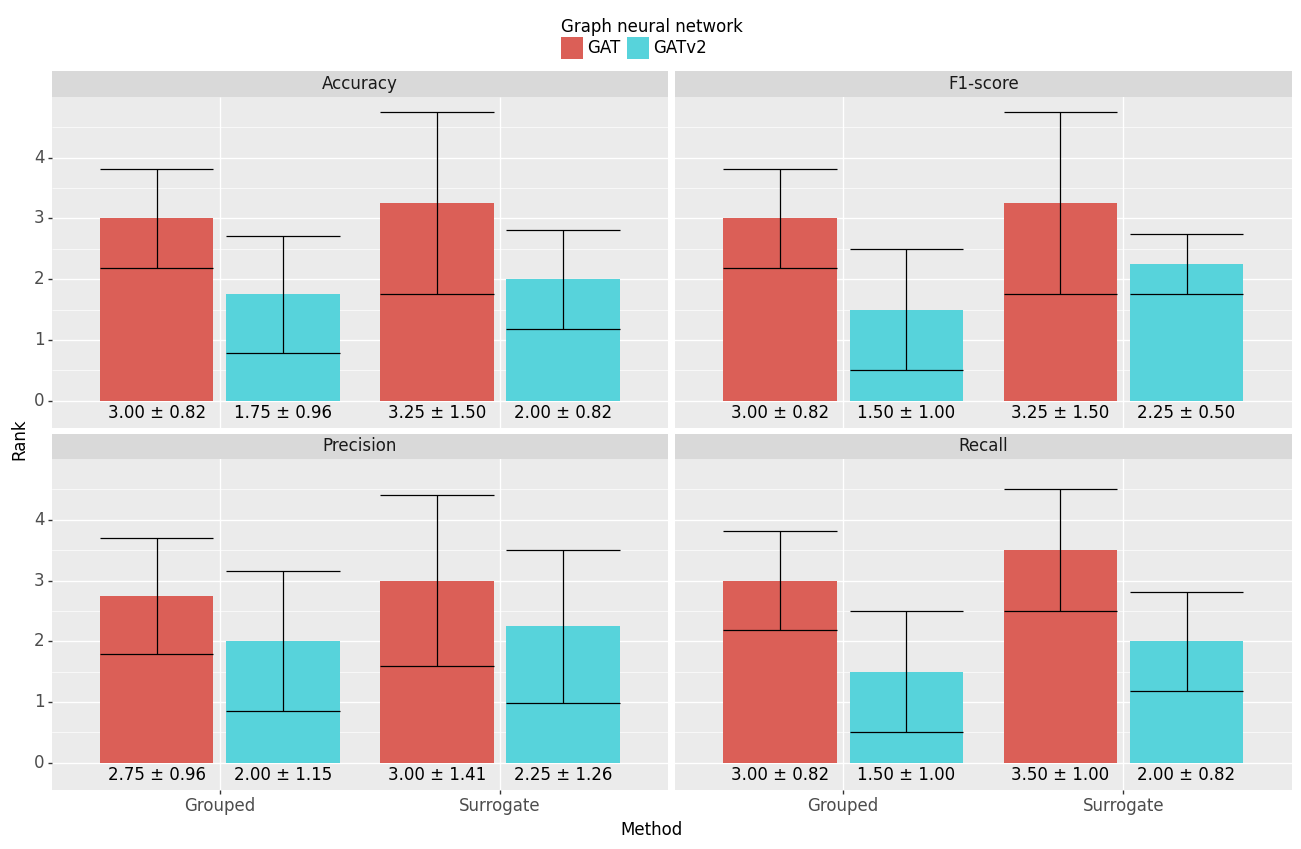

<ggplot: (816589044)>

In [28]:
p9.ggplot(best_results_df_grouped[best_results_df_grouped['split'] == 'Testing'],
  p9.aes(x = 'method', y = 'mean', fill = 'gnn')) + \
  p9.theme_gray() + \
  p9.geom_bar(stat = 'identity', position = p9.position_dodge2()) + \
  p9.geom_errorbar(p9.aes(ymin = 'mean - std', ymax = 'mean + std'), position = p9.position_dodge2(), width = .9) + \
  p9.geom_text(p9.aes(y = -0.2, label = 'label'), position = p9.position_dodge2(width = .9), size = 12) + \
  p9.facet_wrap('~metric', ncol = 2) + \
  p9.xlab('Method') + \
  p9.ylab('Rank') + \
  p9.labs(fill = 'Graph neural network') + \
  p9.theme(
    legend_position = 'top',
    legend_box_margin = 0,
    figure_size = (16, 9),
    text = p9.element_text(size = 12)
  )

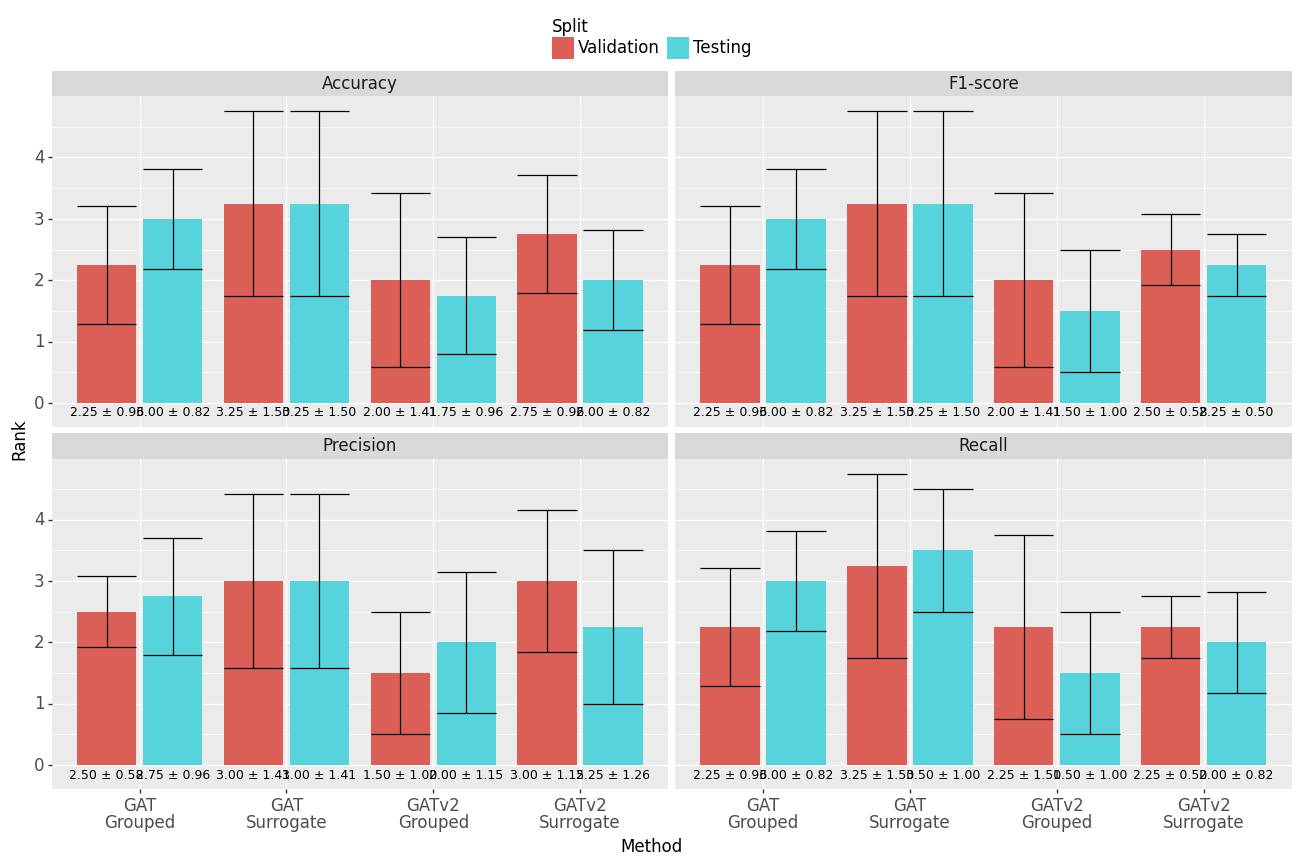

<ggplot: (815668074)>

In [29]:
p9.ggplot(best_results_df_grouped,
  p9.aes(x = 'combination', y = 'mean', fill = 'split')) + \
  p9.theme_gray() + \
  p9.geom_bar(stat = 'identity', position = p9.position_dodge2()) + \
  p9.geom_errorbar(p9.aes(ymin = 'mean - std', ymax = 'mean + std'), position = p9.position_dodge2(), width = .9) + \
  p9.geom_text(p9.aes(y = -0.15, label = 'label'), position = p9.position_dodge2(width = .9), size = 9) + \
  p9.facet_wrap('~metric', ncol = 2) + \
  p9.xlab('Method') + \
  p9.ylab('Rank') + \
  p9.labs(fill = 'Split') + \
  p9.theme(
    legend_position = 'top',
    legend_box_margin = 0,
    figure_size = (16, 9),
    text = p9.element_text(size = 12)
  )

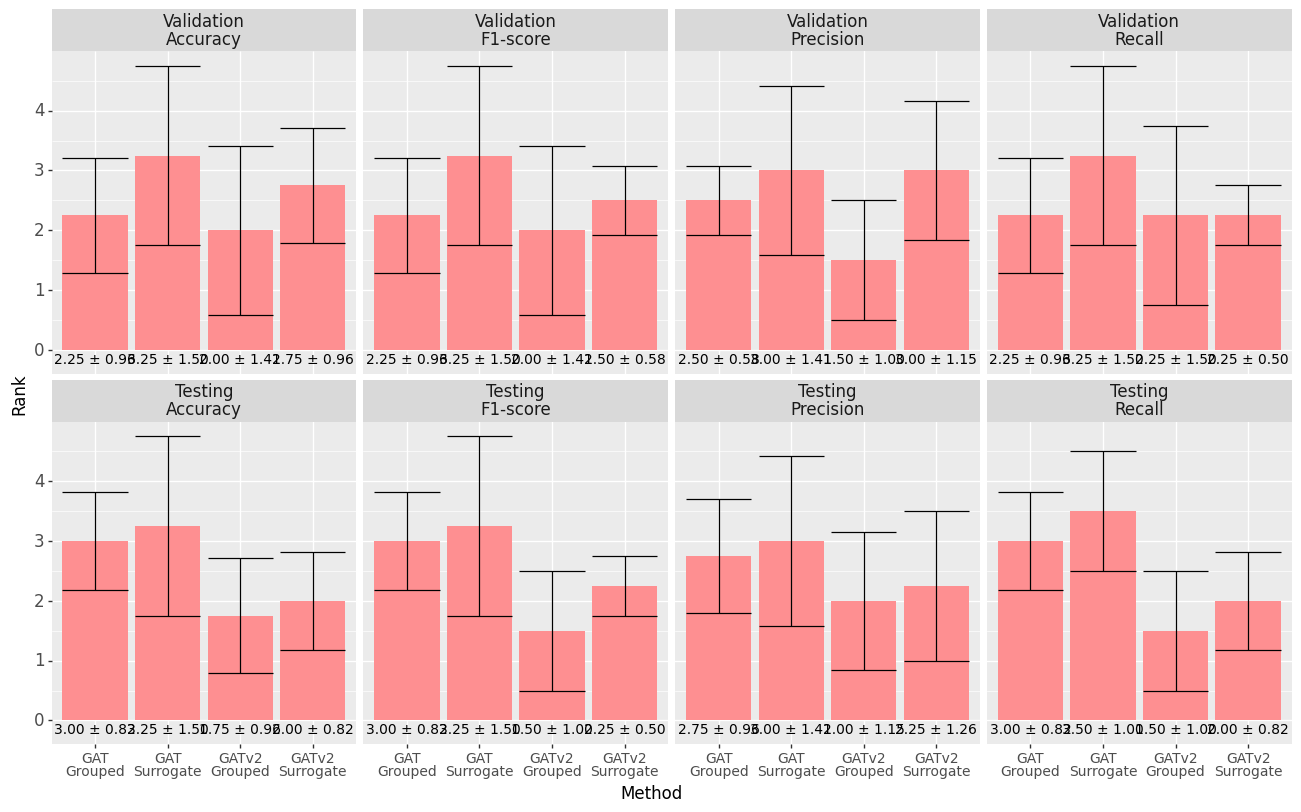

<ggplot: (815535684)>

In [30]:
p9.ggplot(best_results_df_grouped,
  p9.aes(x = 'combination', y = 'mean')) + \
  p9.theme_gray() + \
  p9.geom_bar(stat = 'identity', position = p9.position_dodge2(), fill = '#fe8f91') + \
  p9.geom_errorbar(p9.aes(ymin = 'mean - std', ymax = 'mean + std'), position = p9.position_dodge2(), width = .9) + \
  p9.geom_text(p9.aes(y = -0.15, label = 'label'), position = p9.position_dodge2(width = .9), size = 10) + \
  p9.facet_wrap('~split+metric', ncol = 4) + \
  p9.xlab('Method') + \
  p9.ylab('Rank') + \
  p9.theme(
    legend_position = 'top',
    figure_size = (16, 9),
    text = p9.element_text(size = 12),
    axis_text_x = p9.element_text(size = 10)
  )

## Percentage change analysis

In [31]:
best_results_df.drop(columns = [x for x in best_results_df.columns if x.endswith('_rank')], inplace = True)

In [32]:
best_results_df

,dataset,target_metric,gnn,method,validation_accuracy_mean,validation_accuracy_std,validation_f1_score_mean,validation_f1_score_std,validation_precision_mean,validation_precision_std,validation_recall_mean,validation_recall_std,test_accuracy_mean,test_accuracy_std,test_f1_score_mean,test_f1_score_std,test_precision_mean,test_precision_std,test_recall_mean,test_recall_std
0,SST-2,accuracy,GAT,Grouped,0.900573,0.005015,0.900520,0.004983,0.901154,0.005094,0.900643,0.004809,0.890664,0.005213,0.890604,0.005250,0.891488,0.004808,0.890659,0.005198
1,SST-2,accuracy,GAT,Surrogate,0.896101,0.001964,0.896043,0.001973,0.896407,0.002026,0.896062,0.002034,0.887589,0.006686,0.887551,0.006684,0.888139,0.006749,0.887598,0.006662
2,SST-2,accuracy,GATv2,Grouped,0.902294,0.003096,0.902275,0.003101,0.902460,0.003141,0.902429,0.003134,0.895167,0.007491,0.895155,0.007502,0.895350,0.007336,0.895169,0.007484
3,SST-2,accuracy,GATv2,Surrogate,0.901376,0.005013,0.901344,0.005025,0.901762,0.004761,0.901516,0.004972,0.891763,0.007629,0.891736,0.007623,0.892126,0.007726,0.891752,0.007622
4,R8,f1_score,GAT,Grouped,0.978213,0.001454,0.955244,0.003110,0.946267,0.006445,0.966757,0.003975,0.978209,0.003054,0.944995,0.005403,0.948766,0.008860,0.942897,0.004171
5,R8,f1_score,GAT,Surrogate,0.976026,0.001924,0.946227,0.005369,0.944049,0.007384,0.950020,0.008399,0.975377,0.002201,0.935712,0.005074,0.943834,0.004391,0.931932,0.007374
6,R8,f1_score,GATv2,Grouped,0.978122,0.002718,0.953193,0.004542,0.949558,0.007585,0.958557,0.006382,0.978483,0.002497,0.946604,0.004902,0.950180,0.007487,0.944694,0.006340
7,R8,f1_score,GATv2,Surrogate,0.976481,0.002535,0.949760,0.005209,0.942231,0.004277,0.959057,0.006823,0.976336,0.003250,0.939839,0.005253,0.939268,0.008384,0.942734,0.005832
8,Ohsumed,f1_score,GAT,Grouped,0.695982,0.011676,0.616005,0.017867,0.657668,0.023102,0.615205,0.019109,0.691269,0.006673,0.599304,0.007253,0.622502,0.015395,0.596461,0.014473
9,Ohsumed,f1_score,GAT,Surrogate,0.678125,0.011004,0.596750,0.012948,0.629126,0.023872,0.596999,0.015566,0.671778,0.010327,0.580983,0.010498,0.592018,0.012942,0.583639,0.011887


In [33]:
best_results_df['is_base'] = (best_results_df['gnn'] == 'GAT') & (best_results_df['method'] == 'Grouped')

In [34]:
for column in [x for x in best_results_df.columns if x.endswith('_mean')]:
  best_results_df[f'{column}_change'] = best_results_df[['dataset', column, 'is_base']] \
    .groupby(['dataset']) \
    .apply(
      lambda group: group.apply(
        lambda row: ((row[column] - group.loc[group['is_base'], column].values[0]) / group.loc[group['is_base'], column].values[0]) * 100
          if group['is_base'].any() else None, axis = 1
        )
    ).reset_index(drop = True)

In [35]:
best_results_df = best_results_df[~best_results_df['is_base']]

In [36]:
best_results_df['combination'] = best_results_df['gnn'] + '\n' + best_results_df['method']

In [37]:
best_results_df_melted = best_results_df.drop(columns = ['dataset', 'target_metric']).melt(id_vars = ['gnn', 'method', 'combination'], var_name = 'information', value_name = 'value')
split_information_column = best_results_df_melted['information'].str.split('_')
best_results_df_melted['split'] = split_information_column.str[0]
best_results_df_melted['metric'] = split_information_column.str[1]
best_results_df_melted.drop(columns = ['information'], inplace = True)

In [38]:
best_results_df_melted['metric'] = best_results_df_melted['metric'].replace({'f1' : 'F1-score'}).str.capitalize()
best_results_df_melted['split'] = best_results_df_melted['split'].replace({'test' : 'Testing'}).str.capitalize()
best_results_df_melted['split'] = pd.Categorical(best_results_df_melted['split'], categories = ['Validation', 'Testing'])

In [39]:
best_results_df_melted['value'] = best_results_df_melted['value'].astype(float)

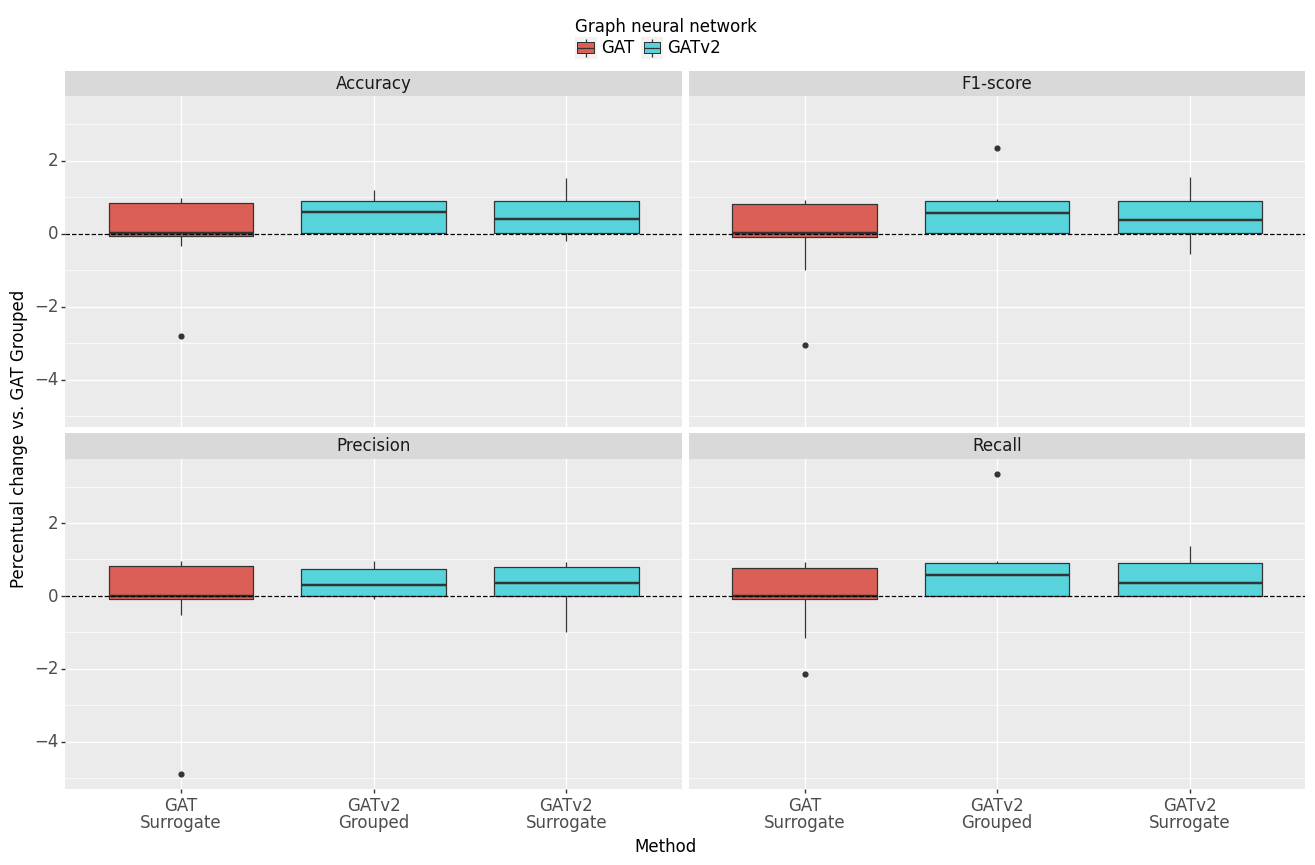

<ggplot: (815252970)>

In [40]:
p9.ggplot(best_results_df_melted[best_results_df_melted['split'] == 'Testing'],
  p9.aes(x = 'combination', y = 'value', fill = 'gnn', group = 'combination')) + \
  p9.theme_gray() + \
  p9.geom_boxplot() + \
  p9.geom_hline(yintercept = 0, linetype = 'dashed') + \
  p9.facet_wrap('~metric', ncol = 2) + \
  p9.xlab('Method') + \
  p9.ylab('Percentual change vs. GAT Grouped') + \
  p9.labs(fill = 'Graph neural network') + \
  p9.theme(
    legend_position = 'top',
    legend_box_margin = 0,
    figure_size = (16, 9),
    text = p9.element_text(size = 12)
  )

In [41]:
best_results_df_grouped = best_results_df.groupby(['gnn', 'method']).agg({
  'validation_accuracy_mean_change' : ['mean', 'std'],
  'test_accuracy_mean_change' : ['mean', 'std'],
  'validation_f1_score_mean_change' : ['mean', 'std'],
  'test_f1_score_mean_change' : ['mean', 'std'],
  'validation_precision_mean_change' : ['mean', 'std'],
  'test_precision_mean_change' : ['mean', 'std'],
  'validation_recall_mean_change' : ['mean', 'std'],
  'test_recall_mean_change' : ['mean', 'std'],
}).reset_index()
best_results_df_grouped.columns = best_results_df_grouped.columns.map('_'.join).str.strip('_')

In [42]:
best_results_df_grouped['combination'] = best_results_df_grouped['gnn'] + '\n' + best_results_df_grouped['method']

In [43]:
best_results_df_grouped = best_results_df_grouped.melt(id_vars = ['gnn', 'method', 'combination'], var_name = 'information', value_name = 'value')
split_information_column = best_results_df_grouped['information'].str.split('_')
best_results_df_grouped['split'] = split_information_column.str[0]
best_results_df_grouped['metric'] = split_information_column.str[1]
best_results_df_grouped['mean_std'] = split_information_column.str[-1]
best_results_df_grouped.drop(columns = ['information'], inplace = True)

In [44]:
best_results_df_grouped = best_results_df_grouped.pivot_table(index = ['gnn', 'method', 'combination', 'split', 'metric'], columns = 'mean_std', values = 'value').reset_index()

In [45]:
best_results_df_grouped['label'] = best_results_df_grouped['mean'].map(lambda x : '{:.2f}'.format(x)) + ' ± ' + best_results_df_grouped['std'].map(lambda x : '{:.2f}'.format(x))

In [46]:
best_results_df_grouped.head()

mean_std,gnn,method,combination,split,metric,mean,std,label
0,GAT,Surrogate,GAT\nSurrogate,test,accuracy,-0.660002,1.535522,-0.66 ± 1.54
1,GAT,Surrogate,GAT\nSurrogate,test,f1,-0.894166,1.620543,-0.89 ± 1.62
2,GAT,Surrogate,GAT\nSurrogate,test,precision,-1.253122,2.498018,-1.25 ± 2.50
3,GAT,Surrogate,GAT\nSurrogate,test,recall,-0.736102,1.215255,-0.74 ± 1.22
4,GAT,Surrogate,GAT\nSurrogate,validation,accuracy,-0.688968,1.324396,-0.69 ± 1.32


In [47]:
best_results_df_grouped['metric'] = best_results_df_grouped['metric'].replace({'f1' : 'F1-score'}).str.capitalize()

In [48]:
best_results_df_grouped['split'] = best_results_df_grouped['split'].replace({'test' : 'Testing'}).str.capitalize()
best_results_df_grouped['split'] = pd.Categorical(best_results_df_grouped['split'], categories = ['Validation', 'Testing'])

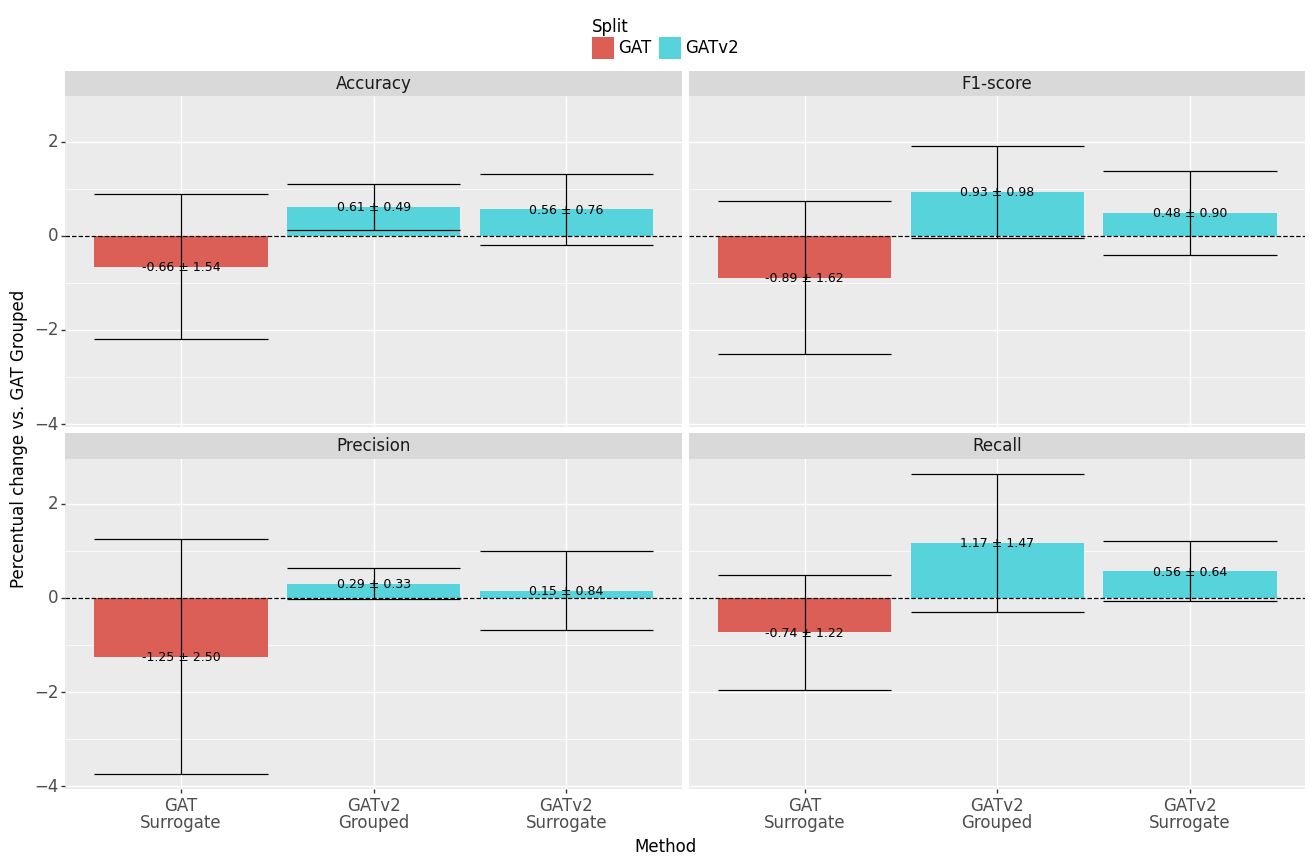

<ggplot: (815679443)>

In [49]:
p9.ggplot(best_results_df_grouped[best_results_df_grouped['split'] == 'Testing'],
  p9.aes(x = 'combination', y = 'mean', fill = 'gnn')) + \
  p9.theme_gray() + \
  p9.geom_bar(stat = 'identity', position = p9.position_dodge2()) + \
  p9.geom_hline(yintercept = 0, linetype = 'dashed') + \
  p9.geom_errorbar(p9.aes(ymin = 'mean - std', ymax = 'mean + std'), position = p9.position_dodge2(), width = .9) + \
  p9.geom_text(p9.aes(label = 'label'), position = p9.position_dodge2(width = .9), size = 9) + \
  p9.facet_wrap('~metric', ncol = 2) + \
  p9.xlab('Method') + \
  p9.ylab('Percentual change vs. GAT Grouped') + \
  p9.labs(fill = 'Split') + \
  p9.theme(
    legend_position = 'top',
    legend_box_margin = 0,
    figure_size = (16, 9),
    text = p9.element_text(size = 12)
  )

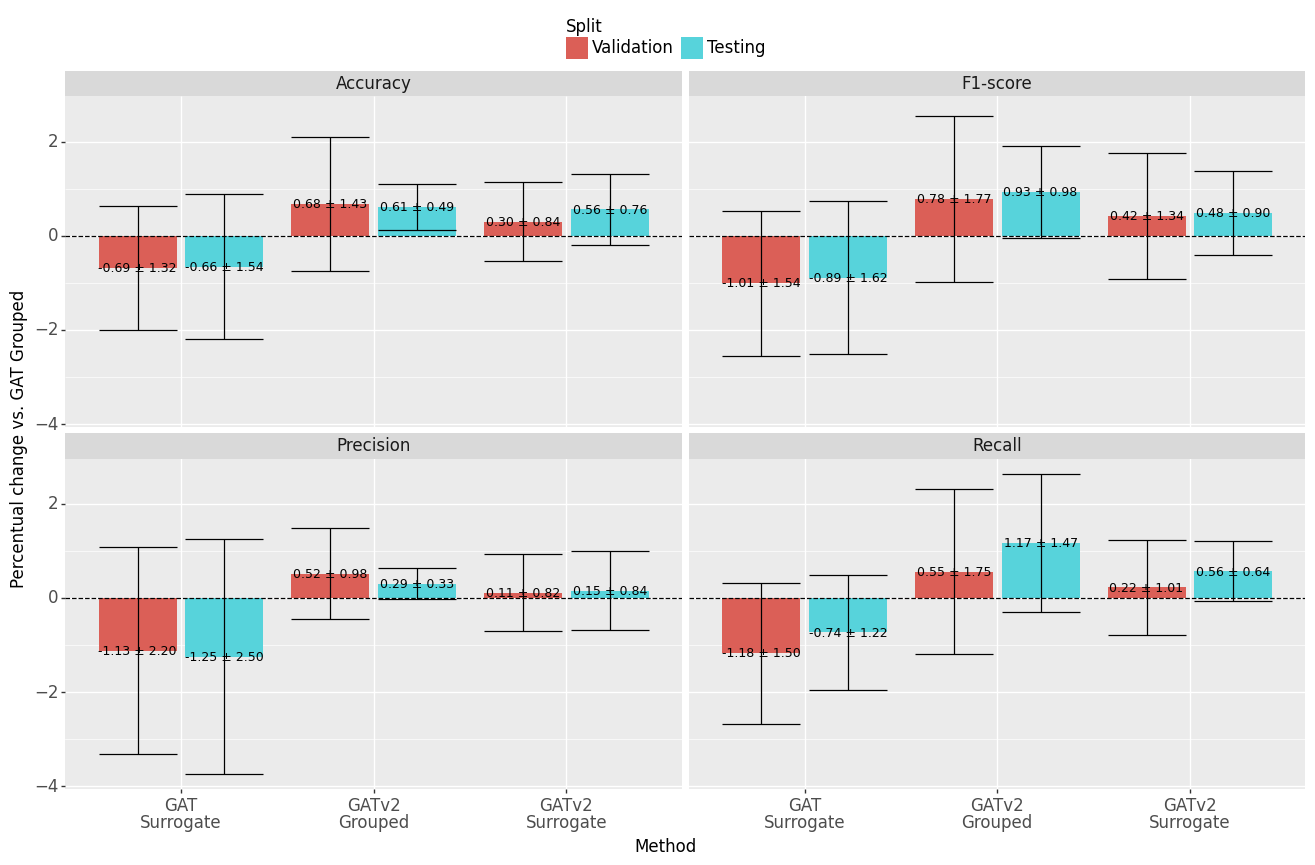

<ggplot: (816007757)>

In [50]:
p9.ggplot(best_results_df_grouped,
  p9.aes(x = 'combination', y = 'mean', fill = 'split')) + \
  p9.theme_gray() + \
  p9.geom_bar(stat = 'identity', position = p9.position_dodge2()) + \
  p9.geom_hline(yintercept = 0, linetype = 'dashed') + \
  p9.geom_errorbar(p9.aes(ymin = 'mean - std', ymax = 'mean + std'), position = p9.position_dodge2(), width = .9) + \
  p9.geom_text(p9.aes(label = 'label'), position = p9.position_dodge2(width = .9), size = 9) + \
  p9.facet_wrap('~metric', ncol = 2) + \
  p9.xlab('Method') + \
  p9.ylab('Percentual change vs. GAT Grouped') + \
  p9.labs(fill = 'Split') + \
  p9.theme(
    legend_position = 'top',
    legend_box_margin = 0,
    figure_size = (16, 9),
    text = p9.element_text(size = 12)
  )

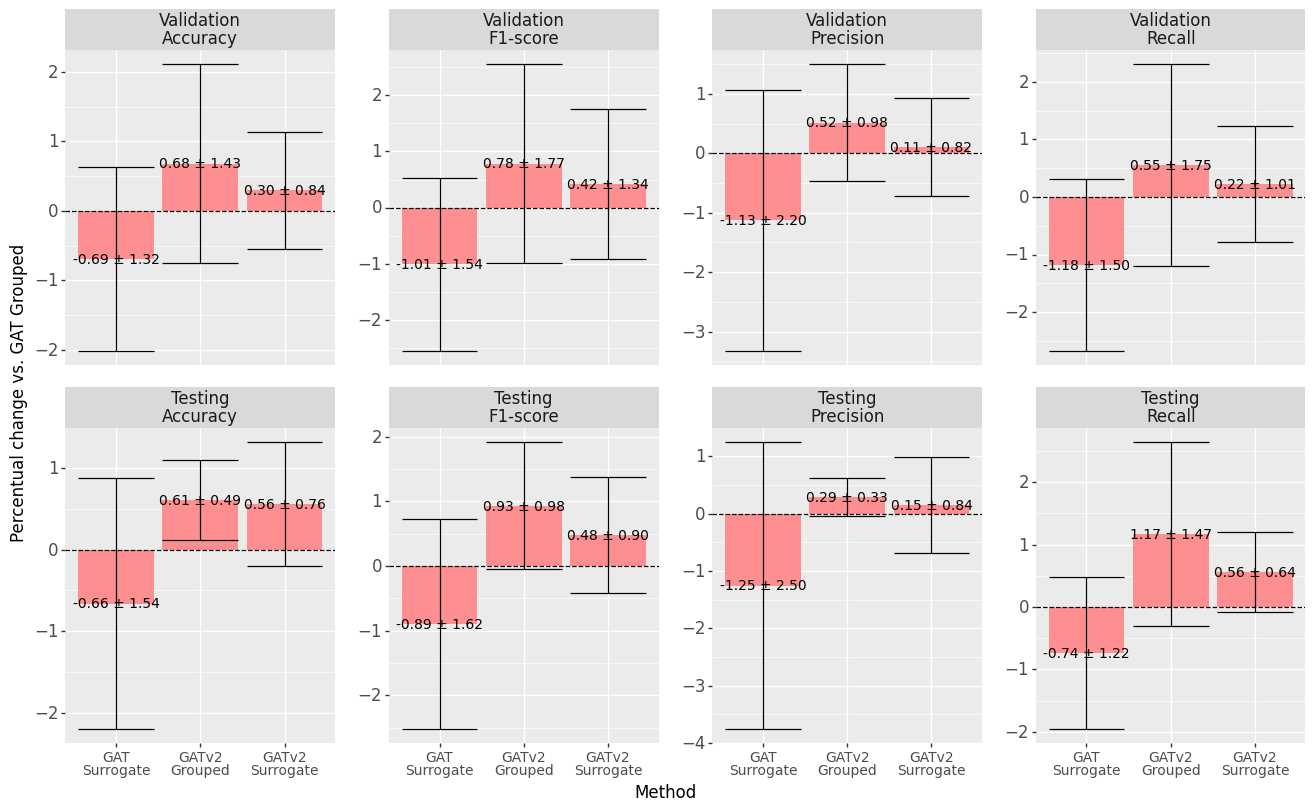

<ggplot: (815505000)>

In [51]:
p9.ggplot(best_results_df_grouped,
  p9.aes(x = 'combination', y = 'mean')) + \
  p9.theme_gray() + \
  p9.geom_bar(stat = 'identity', position = p9.position_dodge2(), fill = '#fe8f91') + \
  p9.geom_hline(yintercept = 0, linetype = 'dashed') + \
  p9.geom_errorbar(p9.aes(ymin = 'mean - std', ymax = 'mean + std'), position = p9.position_dodge2(), width = .9) + \
  p9.geom_text(p9.aes(label = 'label'), position = p9.position_dodge2(width = .9), size = 10) + \
  p9.facet_wrap('~split+metric', ncol = 4, scales = 'free_y') + \
  p9.xlab('Method') + \
  p9.ylab('Percentual change vs. GAT Grouped') + \
  p9.theme(
    legend_position = 'top',
    figure_size = (16, 9),
    text = p9.element_text(size = 12),
    axis_text_x = p9.element_text(size = 10),
    subplots_adjust = {
      'hspace': 0.2,
      'wspace': 0.2
    }
  )

# GATv2 Grouped vs. Surrogate

In [52]:
best_results_df = get_best_results_for_plot(
  datasets = ['SST-2', 'R8', 'Ohsumed', 'IMDb-top_1000'],
  target_metrics = ['accuracy', 'f1_score', 'f1_score', 'accuracy'],
  gnns = ['GATv2'],
  llm = 'google-bert-bert-base-uncased',
  methods = ['Grouped', 'Surrogate'],
  aggregation = 'No_Aggregation'
)

In [53]:
best_results_df['is_base'] = (best_results_df['gnn'] == 'GATv2') & (best_results_df['method'] == 'Grouped')

In [54]:
for column in [x for x in best_results_df.columns if x.endswith('_mean')]:
  best_results_df[f'{column}_change'] = best_results_df[['dataset', column, 'is_base']] \
    .groupby(['dataset']) \
    .apply(
      lambda group: group.apply(
        lambda row: ((row[column] - group.loc[group['is_base'], column].values[0]) / group.loc[group['is_base'], column].values[0]) * 100
          if group['is_base'].any() else None, axis = 1
        )
    ).reset_index(drop = True)

In [55]:
best_results_df = best_results_df[~best_results_df['is_base']]

In [56]:
best_results_df['combination'] = best_results_df['gnn'] + '\n' + best_results_df['method']

In [57]:
best_results_df_melted = best_results_df.drop(columns = ['dataset', 'target_metric']).melt(id_vars = ['gnn', 'method', 'combination'], var_name = 'information', value_name = 'value')
split_information_column = best_results_df_melted['information'].str.split('_')
best_results_df_melted['split'] = split_information_column.str[0]
best_results_df_melted['metric'] = split_information_column.str[1]
best_results_df_melted.drop(columns = ['information'], inplace = True)

In [58]:
best_results_df_melted['metric'] = best_results_df_melted['metric'].replace({'f1' : 'F1-score'}).str.capitalize()
best_results_df_melted['split'] = best_results_df_melted['split'].replace({'test' : 'Testing'}).str.capitalize()
best_results_df_melted['split'] = pd.Categorical(best_results_df_melted['split'], categories = ['Validation', 'Testing'])

In [59]:
best_results_df_melted['value'] = best_results_df_melted['value'].astype(float)

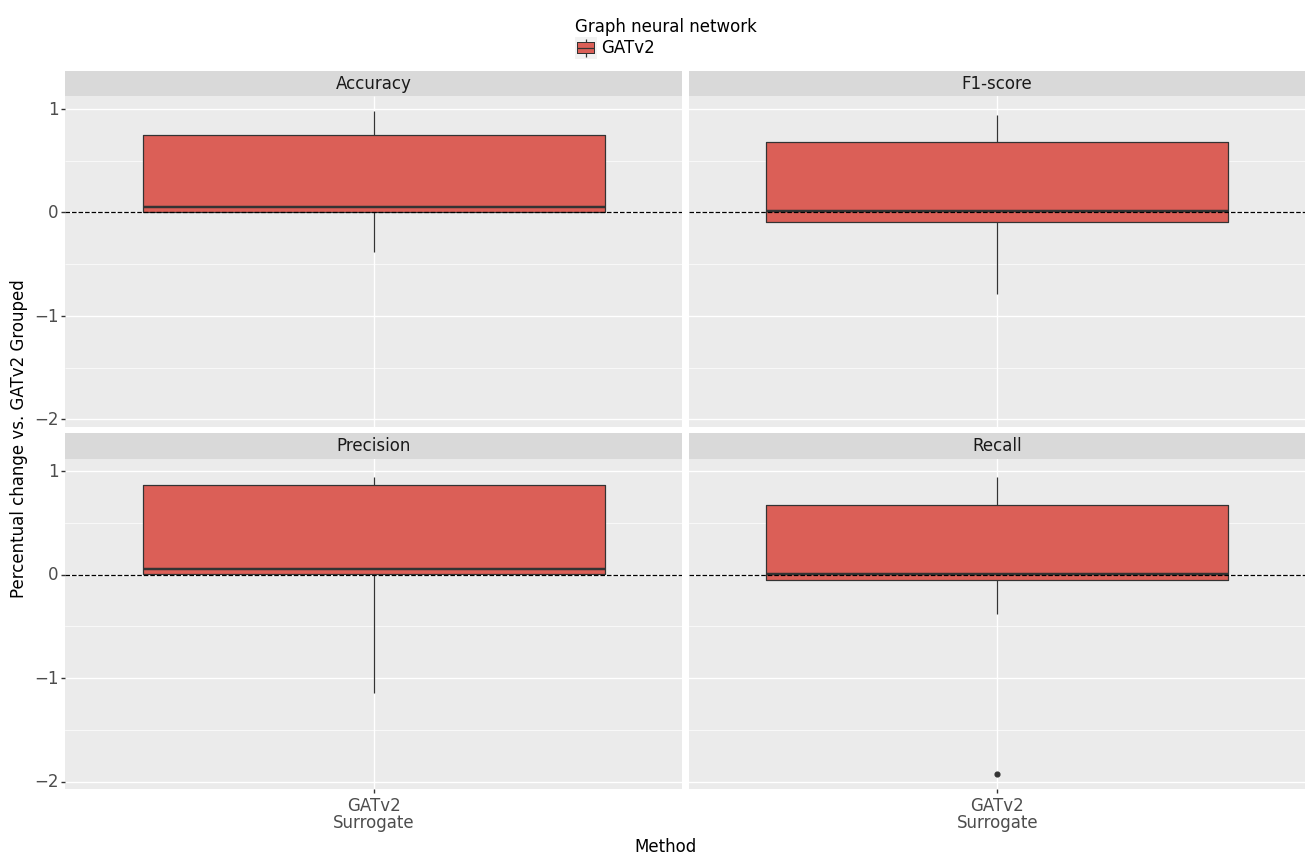

<ggplot: (815511255)>

In [60]:
p9.ggplot(best_results_df_melted[best_results_df_melted['split'] == 'Testing'],
  p9.aes(x = 'combination', y = 'value', fill = 'gnn', group = 'combination')) + \
  p9.theme_gray() + \
  p9.geom_boxplot() + \
  p9.geom_hline(yintercept = 0, linetype = 'dashed') + \
  p9.facet_wrap('~metric', ncol = 2) + \
  p9.xlab('Method') + \
  p9.ylab('Percentual change vs. GATv2 Grouped') + \
  p9.labs(fill = 'Graph neural network') + \
  p9.theme(
    legend_position = 'top',
    legend_box_margin = 0,
    figure_size = (16, 9),
    text = p9.element_text(size = 12)
  )

In [61]:
best_results_df_grouped = best_results_df.groupby(['gnn', 'method']).agg({
  'validation_accuracy_mean_change' : ['mean', 'std'],
  'test_accuracy_mean_change' : ['mean', 'std'],
  'validation_f1_score_mean_change' : ['mean', 'std'],
  'test_f1_score_mean_change' : ['mean', 'std'],
  'validation_precision_mean_change' : ['mean', 'std'],
  'test_precision_mean_change' : ['mean', 'std'],
  'validation_recall_mean_change' : ['mean', 'std'],
  'test_recall_mean_change' : ['mean', 'std'],
}).reset_index()
best_results_df_grouped.columns = best_results_df_grouped.columns.map('_'.join).str.strip('_')

In [62]:
best_results_df_grouped['combination'] = best_results_df_grouped['gnn'] + '\n' + best_results_df_grouped['method']

In [63]:
best_results_df_grouped = best_results_df_grouped.melt(id_vars = ['gnn', 'method', 'combination'], var_name = 'information', value_name = 'value')
split_information_column = best_results_df_grouped['information'].str.split('_')
best_results_df_grouped['split'] = split_information_column.str[0]
best_results_df_grouped['metric'] = split_information_column.str[1]
best_results_df_grouped['mean_std'] = split_information_column.str[-1]
best_results_df_grouped.drop(columns = ['information'], inplace = True)

In [64]:
best_results_df_grouped = best_results_df_grouped.pivot_table(index = ['gnn', 'method', 'combination', 'split', 'metric'], columns = 'mean_std', values = 'value').reset_index()

In [65]:
best_results_df_grouped['label'] = best_results_df_grouped['mean'].map(lambda x : '{:.2f}'.format(x)) + ' ± ' + best_results_df_grouped['std'].map(lambda x : '{:.2f}'.format(x))

In [66]:
best_results_df_grouped.head()

mean_std,gnn,method,combination,split,metric,mean,std,label
0,GATv2,Surrogate,GATv2\nSurrogate,test,accuracy,-0.049671,0.308114,-0.05 ± 0.31
1,GATv2,Surrogate,GATv2\nSurrogate,test,f1,-0.446011,0.407366,-0.45 ± 0.41
2,GATv2,Surrogate,GATv2\nSurrogate,test,precision,-0.140071,0.839247,-0.14 ± 0.84
3,GATv2,Surrogate,GATv2\nSurrogate,test,recall,-0.593715,0.917346,-0.59 ± 0.92
4,GATv2,Surrogate,GATv2\nSurrogate,validation,accuracy,-0.374138,0.572826,-0.37 ± 0.57


In [67]:
best_results_df_grouped['metric'] = best_results_df_grouped['metric'].replace({'f1' : 'F1-score'}).str.capitalize()

In [68]:
best_results_df_grouped['split'] = best_results_df_grouped['split'].replace({'test' : 'Testing'}).str.capitalize()
best_results_df_grouped['split'] = pd.Categorical(best_results_df_grouped['split'], categories = ['Validation', 'Testing'])

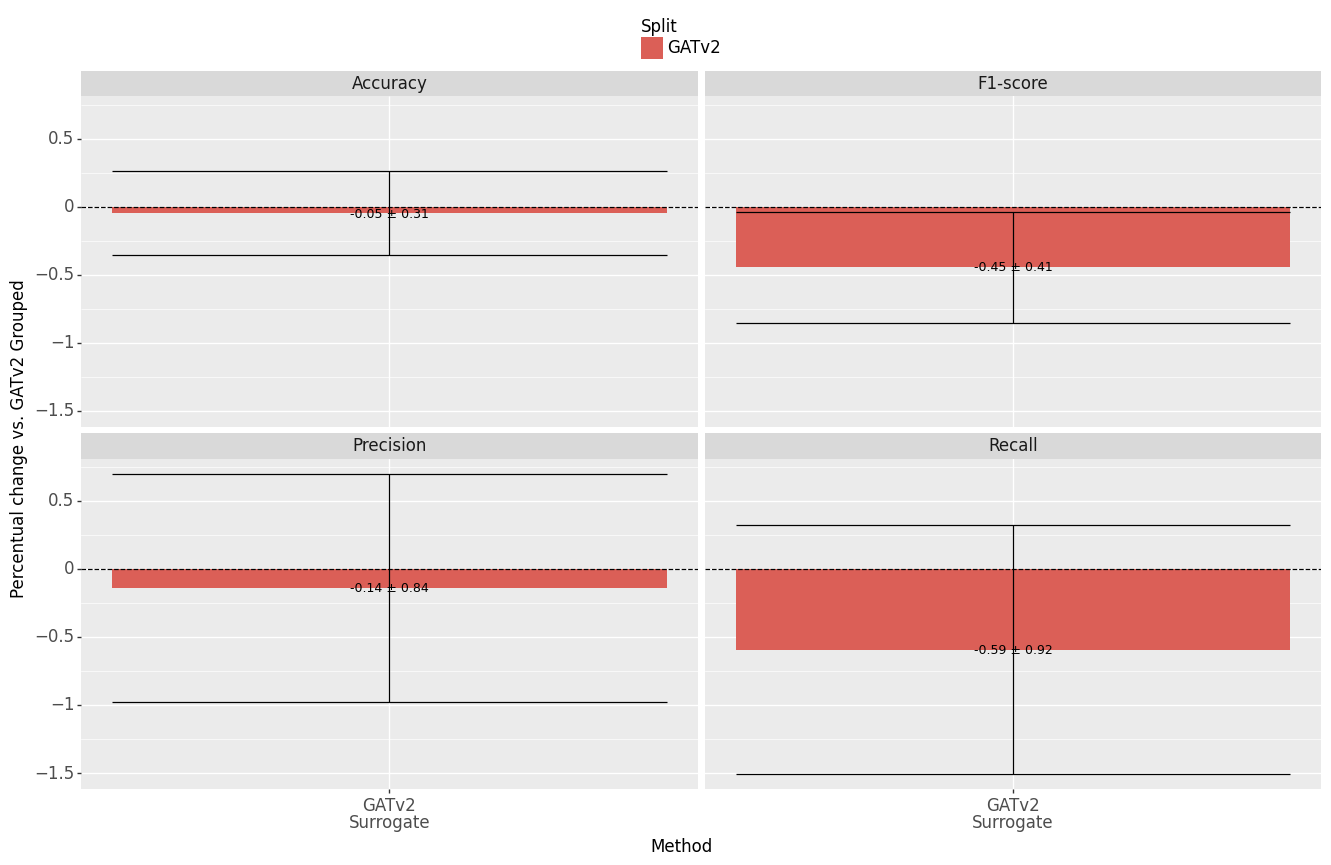

<ggplot: (816499382)>

In [69]:
p9.ggplot(best_results_df_grouped[best_results_df_grouped['split'] == 'Testing'],
  p9.aes(x = 'combination', y = 'mean', fill = 'gnn')) + \
  p9.theme_gray() + \
  p9.geom_bar(stat = 'identity', position = p9.position_dodge2()) + \
  p9.geom_hline(yintercept = 0, linetype = 'dashed') + \
  p9.geom_errorbar(p9.aes(ymin = 'mean - std', ymax = 'mean + std'), position = p9.position_dodge2(), width = .9) + \
  p9.geom_text(p9.aes(label = 'label'), position = p9.position_dodge2(width = .9), size = 9) + \
  p9.facet_wrap('~metric', ncol = 2) + \
  p9.xlab('Method') + \
  p9.ylab('Percentual change vs. GATv2 Grouped') + \
  p9.labs(fill = 'Split') + \
  p9.theme(
    legend_position = 'top',
    legend_box_margin = 0,
    figure_size = (16, 9),
    text = p9.element_text(size = 12)
  )

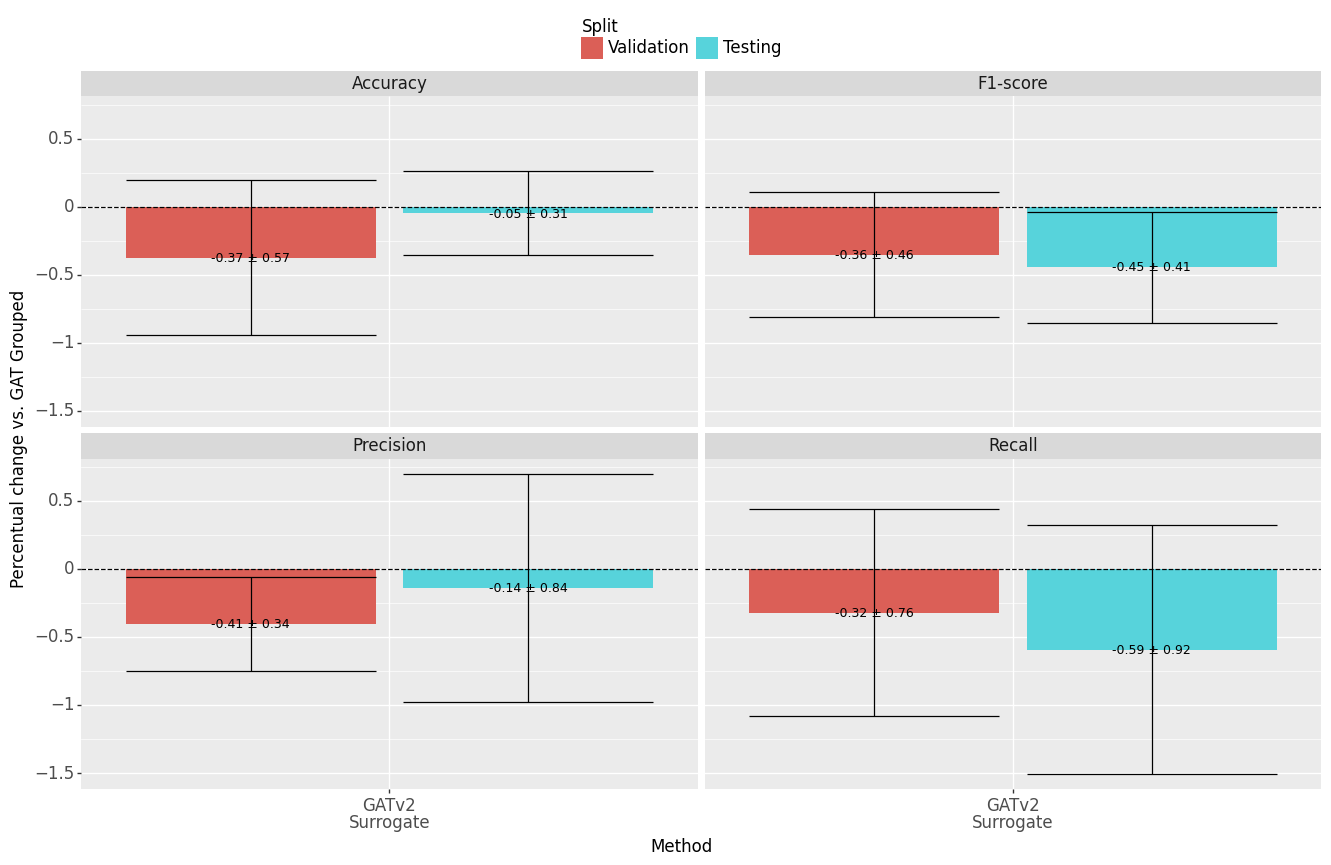

<ggplot: (816499460)>

In [70]:
p9.ggplot(best_results_df_grouped,
  p9.aes(x = 'combination', y = 'mean', fill = 'split')) + \
  p9.theme_gray() + \
  p9.geom_bar(stat = 'identity', position = p9.position_dodge2()) + \
  p9.geom_hline(yintercept = 0, linetype = 'dashed') + \
  p9.geom_errorbar(p9.aes(ymin = 'mean - std', ymax = 'mean + std'), position = p9.position_dodge2(), width = .9) + \
  p9.geom_text(p9.aes(label = 'label'), position = p9.position_dodge2(width = .9), size = 9) + \
  p9.facet_wrap('~metric', ncol = 2) + \
  p9.xlab('Method') + \
  p9.ylab('Percentual change vs. GAT Grouped') + \
  p9.labs(fill = 'Split') + \
  p9.theme(
    legend_position = 'top',
    legend_box_margin = 0,
    figure_size = (16, 9),
    text = p9.element_text(size = 12)
  )

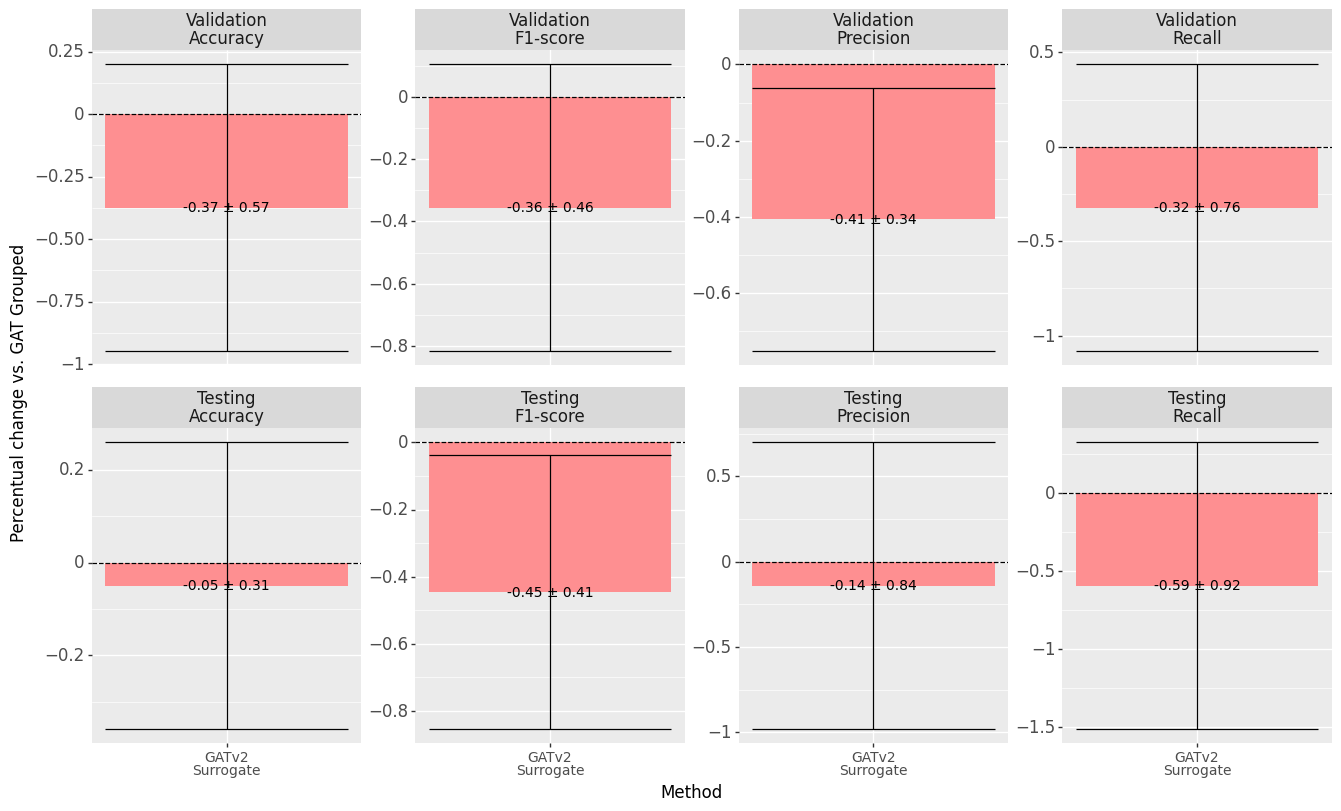

<ggplot: (815853409)>

In [71]:
p9.ggplot(best_results_df_grouped,
  p9.aes(x = 'combination', y = 'mean')) + \
  p9.theme_gray() + \
  p9.geom_bar(stat = 'identity', position = p9.position_dodge2(), fill = '#fe8f91') + \
  p9.geom_hline(yintercept = 0, linetype = 'dashed') + \
  p9.geom_errorbar(p9.aes(ymin = 'mean - std', ymax = 'mean + std'), position = p9.position_dodge2(), width = .9) + \
  p9.geom_text(p9.aes(label = 'label'), position = p9.position_dodge2(width = .9), size = 10) + \
  p9.facet_wrap('~split+metric', ncol = 4, scales = 'free_y') + \
  p9.xlab('Method') + \
  p9.ylab('Percentual change vs. GAT Grouped') + \
  p9.theme(
    legend_position = 'top',
    figure_size = (16, 9),
    text = p9.element_text(size = 12),
    axis_text_x = p9.element_text(size = 10),
    subplots_adjust = {
      'hspace': 0.2,
      'wspace': 0.2
    }
  )

# Statistical significance

In [72]:
def get_best_results_for_statistics(datasets, gnns, llm, methods, aggregation, target_metrics):
  results = list()
  for dataset, target_metric in zip(datasets, target_metrics):
    for gnn in gnns:
      for method in methods:
        df = load_performance_metrics(dataset = dataset, gnn = gnn, llm = llm, method = method, aggregation = aggregation)
        # 'trial', 'random_state', 'split', 'accuracy', 'f1_score', 'precision', 'recall'
        df = remove_trials_with_exceptions(df)
        
        df_aggregated = df.groupby(['trial', 'split']).agg({
          'accuracy' : ['mean', 'std'],
          'f1_score' : ['mean', 'std'],
          'precision' : ['mean', 'std'],
          'recall' : ['mean', 'std'],
        }).reset_index()
        df_aggregated.columns = df_aggregated.columns.map('_'.join).str.strip('_')
        
        best_trial_number = df_aggregated.sort_values(by = ['split', f'{target_metric}_mean', f'{target_metric}_std'], ascending = [True, False, True]).reset_index(drop = True).iloc[0]['trial']
        best_trial = df[df['trial'] == best_trial_number]
        best_trial['target_metric'] = best_trial[target_metric]
        best_trial.drop(columns = ['accuracy', 'f1_score', 'precision', 'recall'], inplace = True)
        best_trial['dataset'] = dataset
        best_trial['gnn'] = gnn
        best_trial['method'] = method
        results.append(best_trial)

  return pd.concat(results, axis = 0)

In [73]:
stats_df = get_best_results_for_statistics(
  datasets = ['SST-2', 'R8', 'Ohsumed', 'IMDb-top_1000'],
  target_metrics = ['accuracy', 'f1_score', 'f1_score', 'accuracy'],
  gnns = ['GATv2'],
  llm = 'google-bert-bert-base-uncased',
  methods = ['Grouped', 'Surrogate'],
  aggregation = 'No_Aggregation'
)

In [74]:
stats_df.head()

,trial,random_state,split,target_metric,dataset,gnn,method
0,221,42,validation,0.907110,SST-2,GATv2,Grouped
1,221,42,test,0.891818,SST-2,GATv2,Grouped
2,221,45,validation,0.902523,SST-2,GATv2,Grouped
3,221,45,test,0.897309,SST-2,GATv2,Grouped
4,221,44,validation,0.902523,SST-2,GATv2,Grouped


In [75]:
# Based on https://www.geeksforgeeks.org/how-to-conduct-a-paired-samples-t-test-in-python/
for i, split in enumerate(['validation', 'test']):
  print(split)
  split_df = stats_df[stats_df['split'] == split].drop(columns = ['trial', 'split', 'gnn'])

  split_df = split_df.pivot(index = ['dataset', 'random_state'], columns = 'method', values = 'target_metric') \
    .reset_index() \
    .sort_values(by = ['dataset', 'random_state'])
  
  # H0: Mean Grouped and Surrogate scores are equal
  # H1: Mean Grouped and Surrogate scores are not equal
  statistic, p_value = stats.ttest_rel(split_df['Grouped'], split_df['Surrogate'])
  # 95% confidence -- p-value < 0.05 => reject the null hypothesis (H0), i.e., the true mean test score is different between Grouped and Surrogate approaches
  print('Statistic:', statistic, 'P-value:', p_value, 'Reject H0?', p_value < 0.05)
  print('')

validation
Statistic: 1.6497165524009894 P-value: 0.10703356294417242 Reject H0? False

test
Statistic: 2.153111406003345 P-value: 0.037553225925305085 Reject H0? True



In [76]:
stats_df = get_best_results_for_statistics(
  datasets = ['SST-2', 'R8', 'Ohsumed', 'IMDb-top_1000'],
  target_metrics = ['accuracy', 'f1_score', 'f1_score', 'accuracy'],
  gnns = ['GAT', 'GATv2'],
  llm = 'google-bert-bert-base-uncased',
  methods = ['Grouped', 'Surrogate'],
  aggregation = 'No_Aggregation'
)

In [77]:
# Based on https://www.geeksforgeeks.org/how-to-conduct-a-paired-samples-t-test-in-python/
for i, split in enumerate(['validation', 'test']):
  print(split)
  gat_split_df = stats_df[(stats_df['split'] == split) & (stats_df['gnn'] == 'GAT')].drop(columns = ['trial', 'split', 'gnn']) \
    .pivot(index = ['dataset', 'random_state'], columns = 'method', values = 'target_metric') \
    .reset_index() \
    .sort_values(by = ['dataset', 'random_state'])
  gatv2_split_df = stats_df[(stats_df['split'] == split) & (stats_df['gnn'] == 'GATv2')].drop(columns = ['trial', 'split', 'gnn']) \
    .pivot(index = ['dataset', 'random_state'], columns = 'method', values = 'target_metric') \
    .reset_index() \
    .sort_values(by = ['dataset', 'random_state'])
  
  split_df = pd.merge(gat_split_df, gatv2_split_df, on = ['dataset', 'random_state'], suffixes = ('_GAT', '_GATv2')) \
    .reset_index() \
    .sort_values(by = ['dataset', 'random_state'])
  
  for (x, y) in itertools.combinations(['Surrogate_GAT', 'Grouped_GAT', 'Grouped_GATv2', 'Surrogate_GATv2'], 2):
    # H0: Mean Grouped and Surrogate scores are equal
    # H1: Mean Grouped and Surrogate scores are not equal
    statistic, p_value = stats.ttest_rel(split_df[x], split_df[y])
    # 95% confidence -- p-value < 0.05 => reject the null hypothesis (H0), i.e., the true mean test score is different between the approaches
    print(f'{x} - {y}:', 'Statistic:', statistic, 'P-value:', p_value, 'Reject H0?', p_value < 0.05)
  print('')

validation
Surrogate_GAT - Grouped_GAT: Statistic: -3.1243824699236376 P-value: 0.003355876737427345 Reject H0? True
Surrogate_GAT - Grouped_GATv2: Statistic: -3.5944374703153747 P-value: 0.0009009495837023746 Reject H0? True
Surrogate_GAT - Surrogate_GATv2: Statistic: -2.7202001936369133 P-value: 0.009693876896967145 Reject H0? True
Grouped_GAT - Grouped_GATv2: Statistic: -2.1571115579215174 P-value: 0.037219081338808836 Reject H0? True
Grouped_GAT - Surrogate_GATv2: Statistic: -0.8722809776377433 P-value: 0.38839386706606327 Reject H0? False
Grouped_GATv2 - Surrogate_GATv2: Statistic: 1.6497165524009894 P-value: 0.10703356294417242 Reject H0? False

test
Surrogate_GAT - Grouped_GAT: Statistic: -2.817555237187092 P-value: 0.007558203067950491 Reject H0? True
Surrogate_GAT - Grouped_GATv2: Statistic: -4.914173562911624 P-value: 1.6414017198936966e-05 Reject H0? True
Surrogate_GAT - Surrogate_GATv2: Statistic: -3.7249812175834185 P-value: 0.0006171903681749932 Reject H0? True
Grouped_GA